In [2]:
import pandas as pd
from sklearn.cross_validation import train_test_split, cross_val_score
import statsmodels.formula.api as smf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn import metrics
from datetime import datetime
from statsmodels.tools.eval_measures import meanabs

from pandas.tools.plotting import scatter_matrix
import random

import matplotlib
%matplotlib inline

import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [18]:
df = pd.read_csv('../csv/combined.csv')
learner_scores = {}

In [19]:
def score(est, X_test, y_test):
    raw_scores = cross_val_score(est, X_test, y=y_test, scoring="mean_absolute_error", cv=10)
    return abs(raw_scores.mean())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f521424bb70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f52097702e8>]], dtype=object)

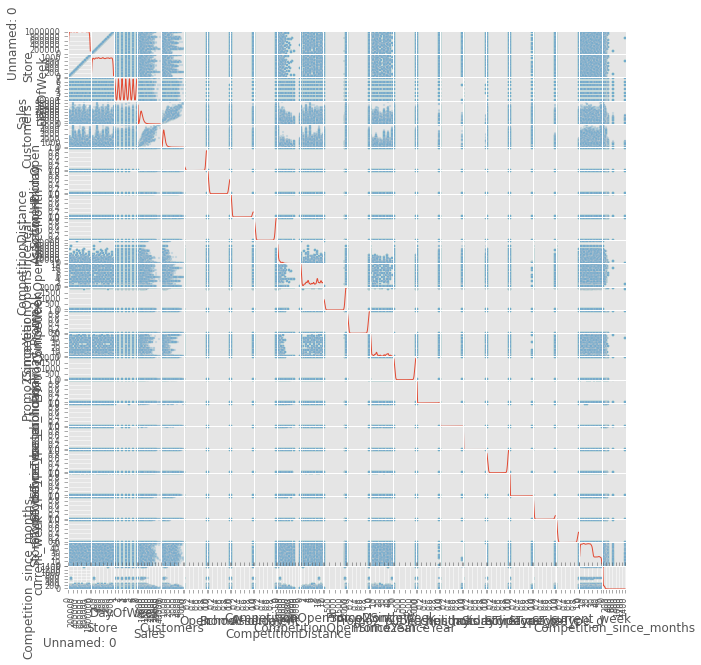

In [20]:
#Requires lots of CPU cycles to generate this scatter_matrix, keep the sample size small
sample_size = int(df['Sales'].size / 5)
sample = df.sample(sample_size)

matplotlib.style.use('ggplot')
scatter_matrix(sample, alpha=0.2, figsize=(10,10), diagonal='kde')

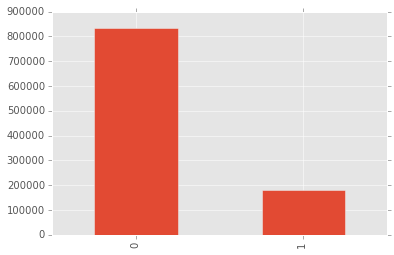

In [21]:
df['SchoolHoliday'].value_counts().plot(kind='bar')

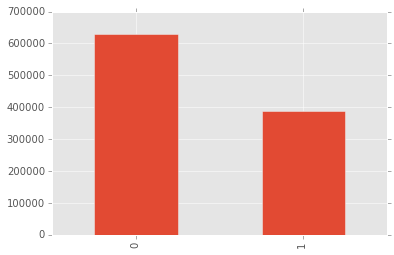

In [22]:
df['Promo'].value_counts().plot(kind='bar')

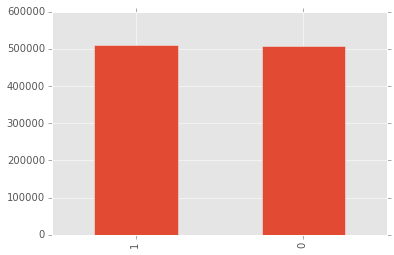

In [23]:
df['Promo2'].value_counts().plot(kind='bar')

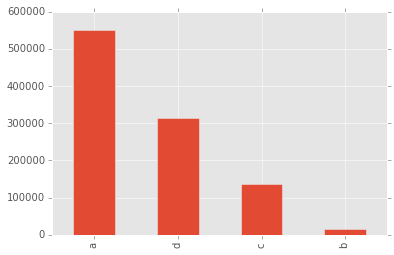

In [24]:
df['StoreType'].value_counts().plot(kind='bar')

In [25]:
def createUnivariateRegression(X_train, y_train):
    estimate = LinearRegression()
    return estimate.fit(X_train, y_train)

def plot(estimate, response, responseLabel, predictor, predictorLabel):
    predictions = estimate.predict(predictor)
    plt.scatter(predictor, response, alpha=0.3)
    plt.xlabel(predictorLabel)
    plt.ylabel(responseLabel)
    plt.plot(predictor, predictions, 'r', alpha=0.9)
    
def splitUnivariateTrainTest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)
    
    #Convert train and test sets into multidimensional versions of themselves 
    X_train = X_train[:, None]
    y_train = y_train[:, None]
    X_test = X_test[:, None]
    y_test = y_test[:, None]
    
    return X_train, X_test, y_train, y_test


    First we'll take the naive approach of fitting a univariate linear regression to the data, considering only
    the competitor's distance as a predictor. We'll do this by splitting the dataset into one for training the model and one for testing it.

1223.8834336


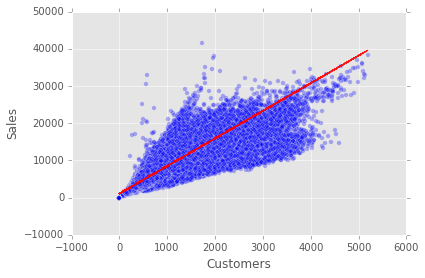

In [26]:
y = df.Sales
X = df.Customers

X_train, X_test, y_train, y_test = splitUnivariateTrainTest(X, y)
customersRegression = createUnivariateRegression(X_train, y_train)
univariate_score = score(customersRegression, X_test, y_test)
learner_scores['Univariate: Customers'] = univariate_score
print(str(univariate_score))
plot(customersRegression, y_test, 'Sales', X_test, 'Customers')

    An R-squared statistic of ~0.8 indicates that the model accounts for most of the variability in the response.

In [27]:
customersRegression.score(X_test, y_test)

0.8007755300735554

    Next we can perform a multivariate linear regression to include each of our predictors when modeling the data.


In [28]:
df = df[['Sales', 'CompetitionDistance', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Promo', 'Promo2', 'SchoolHoliday']]

X = df[['CompetitionDistance', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Promo', 'Promo2', 'SchoolHoliday']]
y = df.Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)

est = sm.OLS(y_train, X_train)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                 2.219e+04
Date:                Wed, 09 Dec 2015   Prob (F-statistic):               0.00
Time:                        12:30:14   Log-Likelihood:            -4.8528e+06
No. Observations:              508604   AIC:                         9.706e+06
Df Residuals:                  508596   BIC:                         9.706e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
CompetitionDistance    -0.0105      0.001    -16.658      0.000        -0.012    -0.009
StoreType_a          4652.2517      9.707    479.262      0.000      4633.226  4671.277
StoreType_b          8750.0693     38.161    229.291      0.000      8675.274  8824.864
StoreType_c          4639.2670     14.694    315.727      0.000      4610.467  4668.067
StoreType_d          4634.3948     12.129    382.105      0.000      4610.623  4658.166
Promo                3552.9320      9.746    364.558      0.000      3533.830  3572.034
Promo2               -665.1144      9.622    -69.125      0.000      -683.973  -646.256
SchoolHoliday         537.6173     12.383     43.417      0.000       513.347   561.887
==============================================================================
Omnibus:                    62892.518   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153976.290
Skew:                           0.721   Prob(JB):                         0.00
Kurtosis:                       5.278   Cond. No.                     7.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
from sklearn.linear_model import LinearRegression
est = LinearRegression()
est.fit(X_train, y_train)
multivariate_score_pregeneration = score(est, X_test, y_test)
learner_scores['Multivariate: pre-generation'] = multivariate_score_pregeneration
print(str(multivariate_score_pregeneration))

2563.36598413


A simple OLS linear regression predicts sales within an error range of 2563

The p-values for each of our predictors are low enough to reject the null hypothesis for each.
Each of the coefficients for our categorical variables have standard error measures between 4 and 6.4, except for
StoreType_b. Should we return to linear regression in this study, it could be fruitful to understand why that might be.

Next we can examine a multiple regression with a subset of interaction terms.

We build one estimator from the Customers, CompetitionDistance, StoreType_a, and Promo features, as well as their
combination of interaction terms. We'll arbitrarily choose StoreType_a and Promo from among our possible binary classifiers.



In [30]:
interaction_formula = 'Sales ~ CompetitionDistance * StoreType_a * Promo'
train, test = train_test_split(df, test_size=.5, random_state=1)

est = sm.OLS.from_formula(interaction_formula, train).fit()
interaction_score = abs(meanabs(est.predict(test), test.Sales))
learner_scores['Interaction: pregeneration'] = interaction_score
print(interaction_score)
est.summary()

2588.05888292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                 1.879e+04
Date:                Wed, 09 Dec 2015   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:            -4.8620e+06
No. Observations:              508604   AIC:                         9.724e+06
Df Residuals:                  508596   BIC:                         9.724e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------
Intercept                              4594.8173     11.920    385.468      0.000      4571.454  4618.180
CompetitionDistance                      -0.0135      0.001     -9.989      0.000        -0.016    -0.011
StoreType_a                            -235.0515     15.383    -15.280      0.000      -265.201  -204.902
CompetitionDistance:StoreType_a           0.0033      0.002      1.971      0.049      1.86e-05     0.007
Promo                                  3334.1492     19.292    172.823      0.000      3296.337  3371.962
CompetitionDistance:Promo                 0.0084      0.002      3.805      0.000         0.004     0.013
StoreType_a:Promo                       402.2848     24.888     16.164      0.000       353.505   451.065
CompetitionDistance:StoreType_a:Promo    -0.0052      0.003     -1.912      0.056        -0.010     0.000
==============================================================================
Omnibus:                    77733.656   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           209985.525
Skew:                           0.840   Prob(JB):                         0.00
Kurtosis:                       5.663   Cond. No.                     8.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We will now explore possible polynomial relationships between certain predictors and sales

In [31]:
def plot_regression(x, est, x_dot, y_dot, predictor, response) :
    # plot lstat (% lower status of the population) against median value
    plt.figure(figsize=(6 * 1.618, 6))
    plt.scatter(x_dot, y_dot, s=10, alpha=0.3)
    plt.xlabel(predictor)
    plt.ylabel(response)
    
    plt.plot(x, est.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % est.rsquared, 
         alpha=0.9)
    
    plt.legend()

In [32]:
df = pd.read_csv('../csv/combined.csv')
df = df.dropna()

In [33]:
train, test = train_test_split(df, test_size = 0.2)

1039.00801974


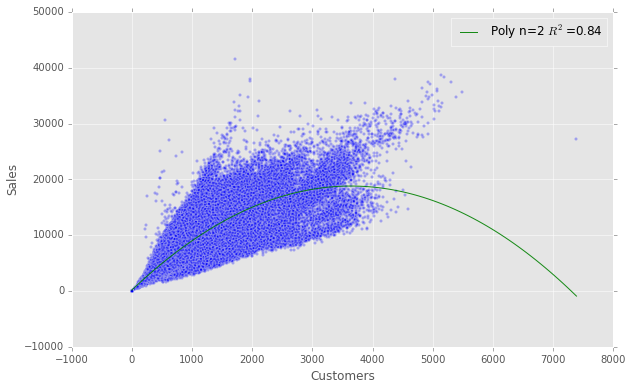

In [34]:
## 2nd degree polynomial plot 

x = pd.DataFrame({'Customers': np.linspace(train.Customers.min(), train.Customers.max(), 100)})
poly_2 = smf.ols(formula='Sales ~ 1 + Customers + I(Customers ** 2.0)', data=train).fit()
x_dot = train.Customers
y_dot = train.Sales

polynomial_customers_score = abs(meanabs(poly_2.predict(test), test.Sales))
learner_scores['Univariate Poly 2: Customers '] = polynomial_customers_score

print(str(polynomial_customers_score))
plot_regression(x,poly_2,x_dot,y_dot,'Customers','Sales')

1016.86137371


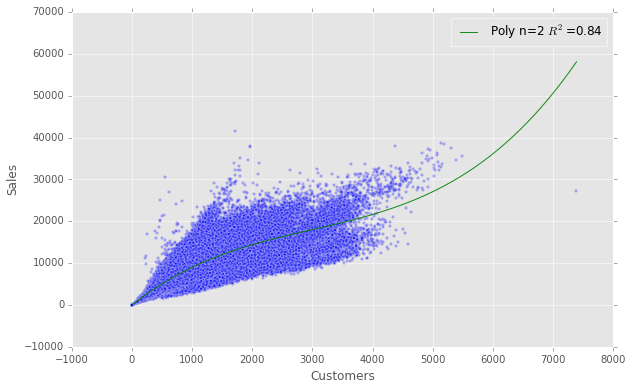

In [35]:
# 3-rd order polynomial
poly_3 = smf.ols(formula='Sales ~ 1 + Customers + I(Customers ** 2.0) + I(Customers ** 3.0)', data=df).fit()

polynomial_customers_score = abs(meanabs(poly_3.predict(test), test.Sales))
learner_scores['Univariate Poly 3: Customers '] = polynomial_customers_score

print(str(polynomial_customers_score))

plot_regression(x,poly_3,x_dot,y_dot,'Customers','Sales')

2889.51348884


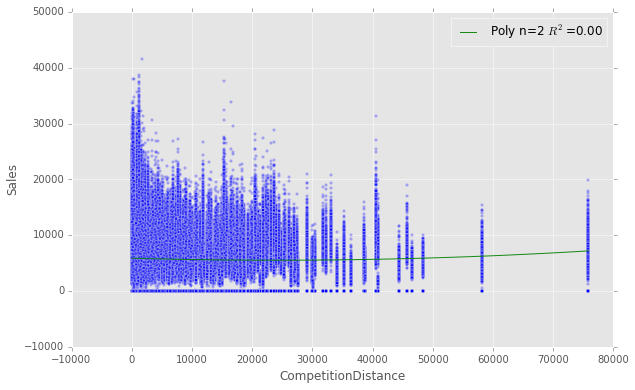

In [36]:
x = pd.DataFrame({'CompetitionDistance': np.linspace(train.CompetitionDistance.min(), train.CompetitionDistance.max(), 100)})
poly_2 = smf.ols(formula='Sales ~ 1 + CompetitionDistance + I(CompetitionDistance ** 2.0)', data=train).fit()
x_dot = train.CompetitionDistance

polynomial_comp_score = abs(meanabs(poly_2.predict(test), test.Sales))
learner_scores['Univariate Poly 2: Comp Distance '] = polynomial_comp_score

print(str(polynomial_comp_score))
plot_regression(x,poly_2,x_dot,y_dot,'CompetitionDistance','Sales')

2890.44314587


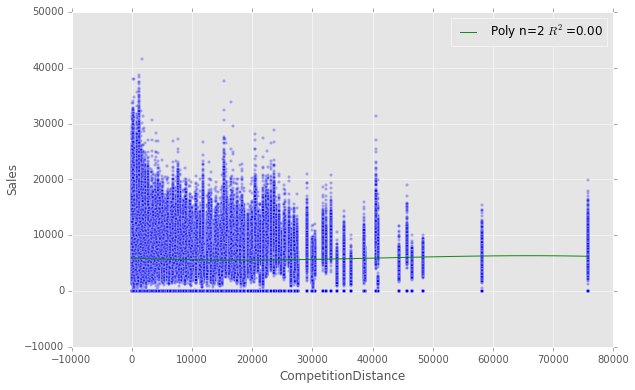

In [37]:
poly_3 = smf.ols(formula='Sales ~ 1 + CompetitionDistance + I(CompetitionDistance ** 2.0) + I(CompetitionDistance ** 3.0)', data=df).fit()


polynomial_comp_score = abs(meanabs(poly_3.predict(test), test.Sales))
learner_scores['Univariate Poly 3: Comp Distance '] = polynomial_comp_score

print(str(polynomial_comp_score))
plot_regression(x,poly_3,x_dot,y_dot,'CompetitionDistance','Sales')

2885.70226445


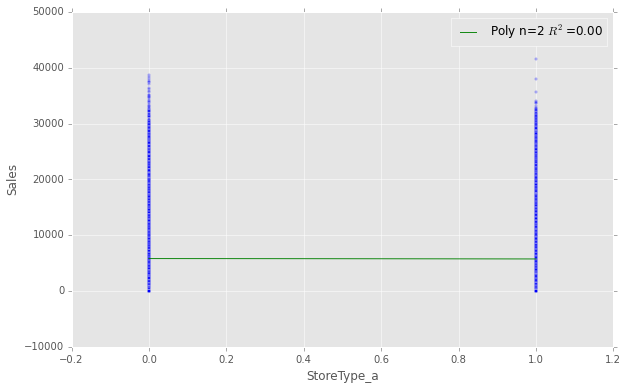

In [38]:
x = pd.DataFrame({'StoreType_a': np.linspace(train.StoreType_a.min(), train.StoreType_a.max(), 100)})
poly_2 = smf.ols(formula='Sales ~ 1 + StoreType_a + I(StoreType_a ** 2.0)', data=train).fit()
x_dot = train.StoreType_a

polynomial_type_score = abs(meanabs(poly_2.predict(test), test.Sales))
learner_scores['Univariate Poly 2: StoreType_a'] = polynomial_type_score

print(str(polynomial_type_score))
plot_regression(x,poly_2,x_dot,y_dot,'StoreType_a','Sales')

Here we begin the process of feature generation. By combining the store.csv dataset with the train.csv dataset, we are able to link store attributes to each of the store records.

In [39]:
def create_training_csv():
    df = pd.read_csv('../csv/train.csv')
    df = merge_store_data(df, '../csv/store.csv')
    df = df.fillna(0)
    df = df[(df['Store'] < 100)]
    df = df[(df['Open'] != 0)]

    create_training_features(df)
    return df

def merge_store_data(df, store_csv_filename):
    storeDf = pd.read_csv(store_csv_filename)
    df = pd.merge(df, storeDf, on='Store')
    return df

def create_training_features(df):
    expand_holiday_features(df)
    generate_store_types(df)
    add_current_week(df)
    generate_customer_metrics(df)
    generate_competition_metrics(df)
    generate_sales_metrics(df)
    generate_promo2_metrics(df)


def generate_store_types(df) :
    df['StoreType_a'] = [1 if val == 'a' else 0 for val in df['StoreType']]
    df['StoreType_b'] = [1 if val == 'b' else 0 for val in df['StoreType']]
    df['StoreType_c'] = [1 if val == 'c' else 0 for val in df['StoreType']]
    df['StoreType_d'] = [1 if val == 'd' else 0 for val in df['StoreType']]
    df['Assortment_a'] = [1 if val == 'a' else 0 for val in df['Assortment']]
    df['Assortment_b'] = [1 if val == 'b' else 0 for val in df['Assortment']]
    df['Assortment_c'] = [1 if val == 'c' else 0 for val in df['Assortment']]


def add_current_week(df):
    def parse_week(date_string):
        return datetime.strptime(date_string, "%Y-%m-%d").isocalendar()[1]

    df['current_week'] = [parse_week(val) for val in df['Date']]

def expand_holiday_features(df):
    df['public_holiday'] = [1 if val == 'a' else 0 for val in df['StateHoliday']]
    df['easter_holiday'] = [1 if val == 'b' else 0 for val in df['StateHoliday']]
    df['christmas_holiday'] = [1 if val == 'c' else 0 for val in df['StateHoliday']]

def generate_competition_metrics(df):

    def get_months(row):

       if row['CompetitionOpenSinceYear'] != 0:
            cur_date = datetime.strptime(row['Date'], "%Y-%m-%d")
            comp_year = int(row['CompetitionOpenSinceYear'])
            comp_month = int(row['CompetitionOpenSinceMonth'])
            comp_date = datetime.strptime(str(comp_year) + "-" + str(comp_month) + "-" + str(1), "%Y-%m-%d")
            val = round(abs((cur_date - comp_date).days) / 30)
            return val
       else:
           return 0

    df['Competition_since_months'] = df.apply(get_months, axis=1)


def generate_promo2_metrics(df):
    generate_promo2_days_since_mailing(df)

def generate_promo2_days_since_mailing(df):

    month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
                 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

    df['promo2_days_since_mailing'] = 0

    def calc_days_since_mailing(row):
        if row['Promo2'] == 0:
            return 0

        curr_date = datetime.strptime(row['Date'], "%Y-%m-%d")
        promo2_date_str = str(int(row['Promo2SinceYear']))+'-W'+str(int(row['Promo2SinceWeek']))+'-0'
        promo2_start = datetime.strptime(promo2_date_str, "%Y-W%W-%w")

        if (curr_date - promo2_start).days <= 0:
            return 0

        interval_months = row['PromoInterval'].split(',')
        month = curr_date.month

        month_str = month_map[month]
        interval_year = curr_date.year
        while month_str not in interval_months:
            month -= 1
            if month == 0:
                month = 12
                interval_year -= 1
            month_str = month_map[month]

        interval_date_str = str(interval_year)+'-'+str(month)+'-1'
        interval_date = datetime.strptime(interval_date_str, "%Y-%m-%d")
        val = (curr_date - interval_date).days
        if val < 0 or val > 95:
            print("blah")
        return (curr_date - interval_date).days

    df['promo2_days_since_mailing'] = df.apply(calc_days_since_mailing, axis=1)


def generate_customer_metrics(df):
    generate_avg_customers_by_week_and_day_by_store(df)
    generate_avg_customers_by_store_school_holiday(df)
    generate_avg_customers_by_store_state_holiday(df)
    generate_customer_statistics_by_store(df)


def generate_customer_statistics_by_store(df):
    max_dictionary = {}
    min_dictionary = {}
    mean_dictionary = {}
    std_dev_dictionary = {}
    min_id = df['Store'].min()
    max_id = df['Store'].max() + 1
    df['max_customers_by_store'] = 0
    df['min_customers_by_store'] = 0
    df['mean_customers_by_store'] = 0
    df['std_dev_customers_by_store'] = 0


    for store_number in range(min_id, max_id):
        store = df[(df['Store'] == store_number)]
        customers = store['Customers']
        max_dictionary[store_number] = customers.max()
        min_dictionary[store_number] = customers.min()
        mean_dictionary[store_number] = customers.mean()
        std_dev_dictionary[store_number] = customers.std()

    def apply_max(row):
        store_id = row['Store']
        return max_dictionary[store_id]

    def apply_min(row):
        store_id = row['Store']
        return min_dictionary[store_id]

    def apply_mean(row):
        store_id = row['Store']
        return mean_dictionary[store_id]

    def apply_std_dev(row):
        store_id = row['Store']
        return std_dev_dictionary[store_id]


    df['mean_customers_by_store'] = df.apply(apply_mean, axis=1)
    df['std_dev_customers_by_store'] = df.apply(apply_std_dev, axis=1)
    df['max_customers_by_store'] = df.apply(apply_max, axis=1)
    df['min_customers_by_store'] = df.apply(apply_min, axis=1)


def generate_avg_customers_by_store_school_holiday(df):
    mean_dictionary = {}
    min_id = df['Store'].min()
    max_id = df['Store'].max() + 1
    df['avg_customers_by_store_school_holiday'] = 0

    for store_number in range(min_id, max_id):
        store = df[(df['Store'] == store_number)]
        store = store[(store['SchoolHoliday'] == 1)]
        mean_dictionary[store_number] = store['Customers'].mean()

    def apply_avg_school_holiday(row):
        store_id = row['Store']
        return mean_dictionary[store_id]

    df['avg_customers_by_store_school_holiday'] = df.apply(apply_avg_school_holiday, axis=1)


def generate_avg_customers_by_store_state_holiday(df):
    mean_dictionary = {}
    min_id = df['Store'].min()
    max_id = df['Store'].max() + 1
    df['avg_customers_by_store_state_holiday'] = 0

    for store_number in range(min_id, max_id):
        store = df[(df['Store'] == store_number)]
        store = store[(store['StateHoliday'] != 0)]
        mean_dictionary[store_number] = store['Customers'].mean()

    def apply_avg_state_holiday(row):
        store_id = row['Store']
        return mean_dictionary[store_id]

    df['avg_customers_by_store_state_holiday'] = df.apply(apply_avg_state_holiday, axis=1)



def generate_sales_metrics(df):
    generate_sales_statistics(df)
    generate_sales_school_state_holiday(df)
    generate_sales_avg_by_store_week_day(df)

def generate_sales_avg_by_store_week_day(df):

    week_dictionary = {}
    day_dictionary = {}

    min_id = df['Store'].min()
    max_id = df['Store'].max() + 1
    df['avg_sales_by_week_for_store'] = 0
    df['avg_sales_by_day_for_store'] = 0

    for store_number in range(min_id, max_id):
        store = df[(df['Store'] == store_number)]
        for week_number in range(1, 53):
            weeks = store[(store['current_week'] == week_number)]
            mean = weeks['Sales'].mean()
            key = str(store_number) + str(week_number)
            week_dictionary[key] = mean

        for i in range(1,8):
           days = store[(store['DayOfWeek'] == i)]
           mean = days['Sales'].mean()
           key = str(store_number) + str(i)
           day_dictionary[key] = mean


    def apply_week_avg(row):
        store_id = row['Store']
        week = row['current_week']
        key = str(store_id) + str(week)
        return week_dictionary[key]

    def apply_day_avg(row):
        store_id = row['Store']
        day = row['DayOfWeek']
        key = str(store_id) + str(day)
        return day_dictionary[key]

    df['avg_sales_by_week_for_store'] = df.apply(apply_week_avg, axis=1)
    df['avg_sales_by_day_for_store'] = df.apply(apply_day_avg, axis=1)


def generate_sales_school_state_holiday(df):
    school_mean_dictionary = {}
    state_mean_dictionary = {}
    min_id = df['Store'].min()
    max_id = df['Store'].max() + 1
    df['avg_sales_by_store_school_holiday'] = 0
    df['avg_sales_by_store_state_holiday'] = 0

    for store_number in range(min_id, max_id):
        store = df[(df['Store'] == store_number)]
        school = store[(store['SchoolHoliday'] == 1)]
        state = store[(store['StateHoliday'] != 0)]
        school_mean_dictionary[store_number] = school['Sales'].mean()
        state_mean_dictionary[store_number] = state['Sales'].mean()


    def apply_avg_school_holiday(row):
        store_id = row['Store']
        return school_mean_dictionary[store_id]

    def apply_avg_state_holiday(row):
        store_id = row['Store']
        return state_mean_dictionary[store_id]

    df['avg_sales_by_store_school_holiday'] = df.apply(apply_avg_school_holiday, axis=1)
    df['avg_sales_by_store_state_holiday'] = df.apply(apply_avg_state_holiday, axis=1)



def generate_sales_statistics(df):
    max_dictionary = {}
    min_dictionary = {}
    mean_dictionary = {}
    std_dev_dictionary = {}
    min_id = df['Store'].min()
    max_id = df['Store'].max() + 1
    df['max_sales_by_store'] = 0
    df['min_sales_by_store'] = 0
    df['mean_sales_by_store'] = 0
    df['std_dev_sales_by_store'] = 0


    for store_number in range(min_id, max_id):
        store = df[(df['Store'] == store_number)]
        sales = store['Sales']
        max_dictionary[store_number] = sales.max()
        min_dictionary[store_number] = sales.min()
        mean_dictionary[store_number] = sales.mean()
        std_dev_dictionary[store_number] = sales.std()

    def apply_max(row):
        store_id = row['Store']
        return max_dictionary[store_id]

    def apply_min(row):
        store_id = row['Store']
        return min_dictionary[store_id]

    def apply_mean(row):
        store_id = row['Store']
        return mean_dictionary[store_id]

    def apply_std_dev(row):
        store_id = row['Store']
        return std_dev_dictionary[store_id]


    df['mean_sales_by_store'] = df.apply(apply_mean, axis=1)
    df['std_dev_sales_by_store'] = df.apply(apply_std_dev, axis=1)
    df['max_sales_by_store'] = df.apply(apply_max, axis=1)
    df['min_sales_by_store'] = df.apply(apply_min, axis=1)



def generate_avg_customers_by_week_and_day_by_store(df):

    week_dictionary = {}
    day_dictionary = {}

    min_id = df['Store'].min()
    max_id = df['Store'].max() + 1
    df['avg_customers_by_week_for_store'] = 0
    df['avg_customers_by_day_for_store'] = 0

    for store_number in range(min_id, max_id):
        store = df[(df['Store'] == store_number)]
        for week_number in range(1, 53):
            weeks = store[(store['current_week'] == week_number)]
            mean = weeks['Customers'].mean()
            key = str(store_number) + str(week_number)
            week_dictionary[key] = mean

        for i in range(1,8):
           days = store[(store['DayOfWeek'] == i)]
           mean = days['Customers'].mean()
           key = str(store_number) + str(i)
           day_dictionary[key] = mean


    def apply_week_avg(row):
        store_id = row['Store']
        week = row['current_week']
        key = str(store_id) + str(week)
        return week_dictionary[key]

    def apply_day_avg(row):
        store_id = row['Store']
        day = row['DayOfWeek']
        key = str(store_id) + str(day)
        return day_dictionary[key]

    df['avg_customers_by_week'] = df.apply(apply_week_avg, axis=1)
    df['avg_customers_by_day'] = df.apply(apply_day_avg, axis=1)

In [40]:
df = create_training_csv()
print(df.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'public_holiday', 'easter_holiday',
       'christmas_holiday', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'current_week', 'avg_customers_by_week_for_store',
       'avg_customers_by_day_for_store', 'avg_customers_by_week',
       'avg_customers_by_day', 'avg_customers_by_store_school_holiday',
       'avg_customers_by_store_state_holiday', 'max_customers_by_store',
       'min_customers_by_store', 'mean_customers_by_store',
       'std_dev_customers_by_store', 'Competition_since_months',
       'max_sales_by_store', 'min_sales_by_store', 'mean_sales_by_store',
       'std_dev_sales_by_store', 'avg_sales_

/home/andrew/anaconda3/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [41]:
features = ['Promo',
        'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'public_holiday', 'easter_holiday',
       'christmas_holiday', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'current_week', 'avg_customers_by_week_for_store',
       'avg_customers_by_day_for_store', 'avg_customers_by_week',
       'avg_customers_by_day', 'avg_customers_by_store_school_holiday',
       'avg_customers_by_store_state_holiday', 'max_customers_by_store',
       'min_customers_by_store', 'mean_customers_by_store',
       'std_dev_customers_by_store',
       'max_sales_by_store', 'min_sales_by_store', 'mean_sales_by_store',
       'std_dev_sales_by_store', 'avg_sales_by_store_school_holiday',
       'avg_sales_by_store_state_holiday', 'avg_sales_by_week_for_store',
       'avg_sales_by_day_for_store', 'promo2_days_since_mailing']

y = df['Sales']
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)
est = sm.OLS(y_train, X_train)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     4853.
Date:                Wed, 09 Dec 2015   Prob (F-statistic):               0.00
Time:                        12:34:00   Log-Likelihood:            -3.1890e+05
No. Observations:               37495   AIC:                         6.379e+05
Df Residuals:                   37465   BIC:                         6.381e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------
Promo                                  1531.4591     14.027    109.183      0.000      1503.967  1558.952
SchoolHoliday                            31.5478     15.865      1.989      0.047         0.453    62.643
CompetitionDistance                      -0.0042      0.001     -3.642      0.000        -0.007    -0.002
Promo2                                 -166.2267     18.332     -9.068      0.000      -202.158  -130.295
public_holiday                          612.1311    215.654      2.838      0.005       189.444  1034.818
easter_holiday                         5135.8431    847.624      6.059      0.000      3474.477  6797.209
christmas_holiday                      1342.6077    692.998      1.937      0.053       -15.687  2700.902
StoreType_a                            -385.1602     17.834    -21.597      0.000      -420.116  -350.204
StoreType_b                             104.6437     74.816      1.399      0.162       -41.997   251.284
StoreType_c                            -426.4269     24.733    -17.241      0.000      -474.904  -377.950
StoreType_d                            -429.8794     21.451    -20.040      0.000      -471.924  -387.835
Assortment_a                           -595.9156     28.847    -20.657      0.000      -652.457  -539.374
Assortment_b                          -1.771e-10   3.12e-11     -5.681      0.000     -2.38e-10 -1.16e-10
Assortment_c                           -540.9074     32.883    -16.450      0.000      -605.358  -476.457
current_week                              6.3411      0.442     14.358      0.000         5.476     7.207
avg_customers_by_week_for_store        4.656e-10   8.15e-11      5.711      0.000      3.06e-10  6.25e-10
avg_customers_by_day_for_store         3.074e-10   5.97e-11      5.153      0.000       1.9e-10  4.24e-10
avg_customers_by_week                    -1.7313      0.117    -14.759      0.000        -1.961    -1.501
avg_customers_by_day                      1.4764      0.245      6.038      0.000         0.997     1.956
avg_customers_by_store_school_holiday     2.2293      0.893      2.496      0.013         0.479     3.980
avg_customers_by_store_state_holiday    -17.3645      6.692     -2.595      0.009       -30.481    -4.248
max_customers_by_store                   -0.1380      0.057     -2.410      0.016        -0.250    -0.026
min_customers_by_store                    0.1906      0.252      0.757      0.449        -0.303     0.685
mean_customers_by_store                  15.2864      6.991      2.186      0.029         1.583    28.990
std_dev_customers_by_store                0.1075      0.669      0.161      0.872        -1.203     1.418
max_sales_by_store                        0.0147      0.006      2.383      0.017         0.003     0.027
min_sales

In [42]:
from sklearn.linear_model import LinearRegression
est = LinearRegression()
est.fit(X_train, y_train)
multivariate_score = score(est, X_test, y_test)
learner_scores['Multivariate: with generation'] = multivariate_score
print(str(multivariate_score))

866.965714051


In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

alphas = [0.0, 1e-8, 1e-5, 1e-1]
best_mean = 5000
best_alpha = -1
best_est = None

for alpha in alphas:
    est = Ridge(alpha=alpha)
    est.fit(X_train, y_train)
    mean = score(est, X_test, y_test)
    if mean < best_mean:
        best_mean = mean
        best_alpha = alpha

learner_scores['Multivariate Ridge'] = best_mean
print(str(best_mean))
print(str(best_alpha))

866.955631101
0.1


In [8]:
import warnings
warnings.filterwarnings('ignore')

forest = RandomForestRegressor()
forest.fit(X_train, y_train)

forest_scores = {}

def create_forest_learner(tree_number):
    forest = RandomForestRegressor(n_estimators=(10**tree_number))
    forest.fit(X_train, y_train)
    forest_raw_scores = cross_val_score(forest, X, y=y, scoring="mean_absolute_error", cv=10)
    forest_scores[tree_number] = abs(forest_raw_scores.mean())

for i in range(0, 4):
    create_forest_learner(i)


0.842753541282


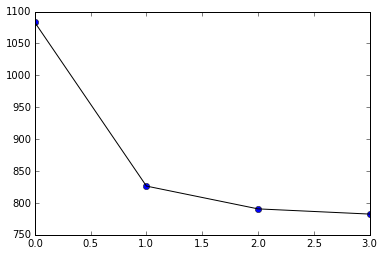

In [9]:
num_trees = [k for (k,v) in forest_scores.items()]
mse = [v for (k, v) in forest_scores.items()]
plt.plot(num_trees, mse, 'bo', num_trees, mse, 'k')

In [137]:
best_forest = RandomForestRegressor(n_estimators=(10**3))
best_forest.fit(X_train, y_train)
forest_score = score(best_forest, X_test, y_test)
learner_scores['Random Forest: 10^3 trees'] = forest_score

In [138]:
print(str(forest_score))

687.069314273


In [6]:
from sklearn.svm import SVR

y = df['Sales']
X = df[features]

scores_per_c_rbf= {}
scores_per_c_poly= {}

def create_svrs_rbf(c_val):
    svr = SVR(C=(10**c_val), epsilon=0.2, kernel='rbf', cache_size=3000)
    svr_raw_scores = cross_val_score(svr, X, y=y, scoring="mean_absolute_error", cv=2)
    scores_per_c_rbf[c_val] = abs(svr_raw_scores.mean())
    
def create_svrs_poly(c_val):
    svr = SVR(C=(10**c_val), epsilon=0.2, kernel='poly', degree=2, cache_size=3000)
    svr_raw_scores = cross_val_score(svr, X, y=y, scoring="mean_absolute_error", cv=2)
    scores_per_c_poly[c_val] = abs(svr_raw_scores.mean())

for i in range(-3, 5):
    create_svrs_rbf(i)

In [15]:
rbf_c_vals = [i for i in range(-3,5)]
rbf_mse = [abs(scores_per_c_rbf[i]) for i in range(-3,5)]

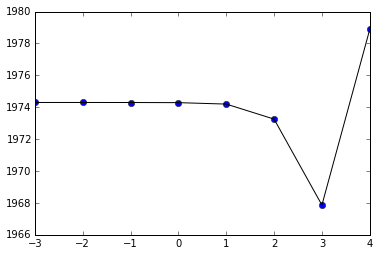

In [16]:
plt.plot(rbf_c_vals, rbf_mse, 'bo', rbf_c_vals, rbf_mse, 'k')

Search for the optimal C value between 3 and 4

In [7]:
scores_per_c_rbf= {}
for i in range(1, 10):
    create_svrs_rbf(3 + (i*.1))

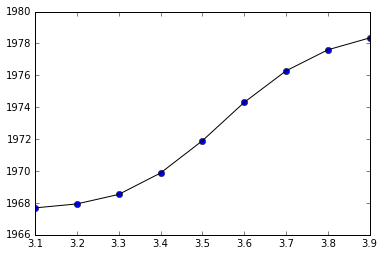

In [8]:
rbf_c_vals = [3 + (i*.1) for i in range(1,10)]
rbf_mse = [abs(scores_per_c_rbf[3 + (i*.1)]) for i in range(1,10)]
plt.plot(rbf_c_vals, rbf_mse, 'bo', rbf_c_vals, rbf_mse, 'k')

In [139]:
best_svr = SVR(C=(10**3), epsilon=0.2, kernel='rbf', cache_size=3000)
svr_score = score(best_svr, X_test, y_test)
learner_scores['SVR: C=10^3'] = svr_score
print(str(svr_score))

1711.52887942


In [ ]:
for i in range(-3, 5):
    create_svrs_poly(i)

In [ ]:
poly_c_vals = [k for (k,v) in scores_per_c_poly.items()]
poly_mse = [v for (k, v) in scores_per_c_poly.items()]

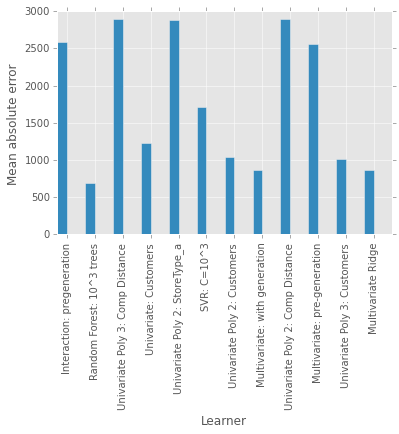

In [44]:
learners = [k for (k,v) in learner_scores.items()]
scores = [learner_scores[k] for (k,v)  in learner_scores.items()]
bar_width =.35
index = np.arange(len(learners))
plt.bar(index, scores, bar_width)
plt.xlabel('Learner')
plt.ylabel('Mean absolute error')
plt.xticks(index + bar_width, learners, rotation='vertical')
plt.figure(figsize=(20,20))
plt.show()

In [155]:
print(learner_scores)

{'Univariate Poly 2: Comp Distance ': 2891.6625805730955, 'Multivariate Ridge': 866.95563110136607, 'SVR: C=10^3': 1711.5288794228222, 'Random Forest: 10^3 trees': 687.06931427254381, 'Univariate Poly 2: StoreType_a': 2892.6546483108787, 'Univariate Poly 3: Customers ': 1018.8543281489085, 'Univariate Poly 2: Customers ': 1041.2458513370439, 'Univariate: Customers': 1223.8834335980723, 'Multivariate: with generation': 866.9657140508059, 'Univariate Poly 3: Comp Distance ': 2892.6546483108787, 'Multivariate: pre-generation': 866.9657140508059}
